In [1]:
# coding: utf-8
import os, getpass

if getpass.getuser()=='jovyan':
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.h
#http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#http://scikit-learn.org/stable/tutorial/basic/tutorial.html#model-persistence
from sklearn.externals import joblib
#https://en.wikipedia.org/wiki/Activation_function
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.layers import Merge, merge
from keras import backend as K
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
import numpy as np
import pandas as pd
import sys, glob, argparse, h5py
from itertools import cycle
from scipy import interp
#from ipywidgets import FloatProgress
#from IPython.display import display
#https://github.com/tqdm/tqdm#latest-conda-release
from tqdm import trange, tqdm
from MLJEC_MCTruth_Util import rotate_and_reflect, prepare_df_dict, JetImageGenerator
import MLJEC_MCTruth_Plot as plotter

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
# get input numpy arrays
inputs = {}
inputs['QCD80'] = glob.glob('QCD_pt_80_120.npy')
inputs['QCD120'] = glob.glob('QCD_pt_120_170.npy')
inputs['QCD170'] = glob.glob('QCD_pt_170_300.npy')
list_params = {}
params = {}
for key, input_files in inputs.iteritems():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print 'bad file: %s'%in_file
    params[key] = np.concatenate(list_params[key])

In [3]:
print params['QCD80'].dtype.names

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_area', 'jet_jes', 'chf', 'nhf', 'phf', 'elf', 'muf', 'hf_hf', 'hf_phf', 'hf_hm', 'hf_phm', 'chm', 'nhm', 'phm', 'elm', 'mum', 'beta', 'bstar', 'ak5pfcand_pt', 'ak5pfcand_eta', 'ak5pfcand_phi', 'ak5pfcand_id', 'ak5pfcand_charge', 'ak5pfcand_ijet')


In [4]:
df_dict_jet = {}
df_dict_cand = {}

In [5]:
for QCDBin in ['QCD80','QCD120','QCD170']:
    df_dict_jet[QCDBin] = pd.DataFrame(params[QCDBin],columns=['run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_area', 'jet_jes', 'chf', 'nhf', 'phf', 'elf', 'muf', 'hf_hf', 'hf_phf', 'hf_hm', 'hf_phm', 'chm', 'nhm', 'phm', 'elm', 'mum', 'beta', 'bstar','ak5pfcand_ijet'])
    df_dict_jet[QCDBin] = df_dict_jet[QCDBin].drop_duplicates()
    df_dict_jet[QCDBin] = df_dict_jet[QCDBin][(df_dict_jet[QCDBin].jet_pt > 80)]
    df_dict_cand[QCDBin] = pd.DataFrame(params[QCDBin], columns=['event', 'jet_pt', 'jet_eta', 'jet_phi','ak5pfcand_pt', 'ak5pfcand_eta', 'ak5pfcand_phi', 'ak5pfcand_id', 'ak5pfcand_charge', 'ak5pfcand_ijet'])
    df_dict_cand[QCDBin] = df_dict_cand[QCDBin][(df_dict_cand[QCDBin].jet_pt > 80)]

In [6]:
df_dict_jets = pd.concat([df_dict_jet['QCD80'],df_dict_jet['QCD120'],df_dict_jet['QCD170']])
df_dict_cands = pd.concat([df_dict_cand['QCD80'],df_dict_cand['QCD120'],df_dict_cand['QCD170']])


In [7]:
####################
# Global Variables #
####################
nx = 25 # size of image in eta
ny = 25 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [8]:

# rotation + (possible) reflection needed later
def rotate_and_reflect(x,y,w):
    rot_x = []
    rot_y = []
    theta = 0
    maxPt = -1
    for ix, iy, iw in zip(x, y, w):
        dv = np.matrix([[ix],[iy]])-np.matrix([[x.iloc[0]],[y.iloc[0]]])
        dR = np.linalg.norm(dv)
        thisPt = iw
        if dR > 0.35 and thisPt > maxPt:
            maxPt = thisPt
            # rotation in eta-phi plane c.f  https://arxiv.org/abs/1407.5675 and https://arxiv.org/abs/1511.05190:
            # theta = -np.arctan2(iy,ix)-np.radians(90)
            # rotation by lorentz transformation c.f. https://arxiv.org/abs/1704.02124:
            px = iw * np.cos(iy)
            py = iw * np.sin(iy)
            pz = iw * np.sinh(ix)
            theta = np.arctan2(py,pz)+np.radians(90)

    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        # rotation in eta-phi plane:
        #rot = R*np.matrix([[ix],[iy]])
        #rix, riy = rot[0,0], rot[1,0]
        # rotation by lorentz transformation
        px = iw * np.cos(iy)
        py = iw * np.sin(iy)
        pz = iw * np.sinh(ix)
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        rot_x.append(rix)
        rot_y.append(riy)

    # now reflect if leftSum > rightSum
    leftSum = 0
    rightSum = 0
    for ix, iy, iw in zip(x, y, w):
        if ix > 0:
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if leftSum > rightSum:
        ref_x = [-1.*rix for rix in rot_x]
        ref_y = rot_y
    else:
        ref_x = rot_x
        ref_y = rot_y

    return np.array(ref_x), np.array(ref_y)



In [9]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm 
    return x / (K.sqrt(K.mean(K.square(x)))+1e-5)

In [10]:
list_x = []
list_y = []
list_w = []
njets = 0
# 4D tensor
# 1st dim is jet index
# 2nd dim is pt value (or rgb, etc.)
# 3rd dim is eta bin
# 4th dim is phi bin
if K.image_dim_ordering()=='tf':
    jet_images = np.zeros((len(df_dict_jets), nx, ny, 1))
else:
    jet_images = np.zeros((len(df_dict_jets), 1, nx, ny))

for i in range(0, len(df_dict_jets)):
    njets+=1
    #get the ith jet 
    df_dict_cand_i = df_dict_cands[(df_dict_cands['ak5pfcand_ijet'] == df_dict_jets['ak5pfcand_ijet'].iloc[i]) &
                                   (df_dict_cands['event'] == df_dict_jets['event'].iloc[i]) &
                                   (df_dict_cands['jet_pt'] == df_dict_jets['jet_pt'].iloc[i])]
    x = df_dict_cand_i['ak5pfcand_eta']-df_dict_cand_i['ak5pfcand_eta'].iloc[0]
    y = df_dict_cand_i['ak5pfcand_phi']-df_dict_cand_i['ak5pfcand_phi'].iloc[0]
    weights = df_dict_cand_i['ak5pfcand_pt'] # pt of candidate is the weight
    #x,y = rotate_and_reflect(x,y,weights)
    list_x.append(x)
    list_y.append(y)
    list_w.append(weights)
    hist, xedges, yedges = np.histogram2d(x, y,weights=weights, bins=(xbins,ybins))
    for ix in range(0,nx):
        for iy in range(0,ny):
            if K.image_dim_ordering()=='tf':
                jet_images[i,ix,iy,0] = hist[ix,iy]
            else:
                jet_images[i,0,ix,iy] = hist[ix,iy]
all_x = np.concatenate(list_x)
all_y = np.concatenate(list_y)
all_w = np.concatenate(list_w)
all_w = 1.*all_w/njets # to get average


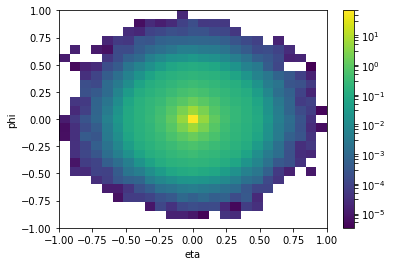

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
    
plt.figure('W')
plt.hist2d(all_x, all_y, weights=all_w, bins=(xbins,ybins), norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('eta')
plt.ylabel('phi')
plt.show()

In [12]:
jet_images.shape

(52992, 25, 25, 1)

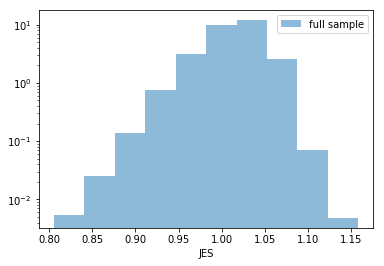

In [13]:
plt.hist(df_dict_jets['jet_jes'], label='full sample', alpha=0.5, normed=True)
plt.legend()
plt.yscale('log')
plt.xlabel('JES')
plt.show()

In [14]:
scaler = StandardScaler()
df_dict_jets['jet_pt'] = scaler.fit_transform(df_dict_jets['jet_pt'].reshape(-1,1))
# normalize jet eta
df_dict_jets['jet_eta'] /= 2.5
#normalize jet phi
df_dict_jets['jet_phi'] /= 3.14


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [15]:
'''
from keras.layers.advanced_activations import LeakyReLU, PReLU
input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(15, 9, 9, border_mode='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
#layer = Convolution2D(15, 9, 9, border_mode='same')(layer)
#layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, 7, 7, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(8, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(6, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
#layer = Convolution2D(4, 5, 5, border_mode='same')(layer)
#layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Flatten()(layer)
# additional features input
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_eta_ak7_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
layer = merge([layer, jet_pt_ak7_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
#layer = Dropout(0.20)(layer)
# changing from softplus to tanh
#other activation option 'sigmoid' better for bounded problem
output_layer = Dense(1, activation='relu', name='main_output')(layer)
#output_layer = LeakyReLU('alpha=0.3')
#model.add(LeakyReLU(alpha=.001))
model = Model(input=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], output=output_layer)
#model = Model(input=input_layer, output=output_layer)
#model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy','precision','mse','msle'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','precision','mse','msle'])
model.summary()
'''

#import os, getpass
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['CUDA_VISIBLE_DEVICES']='2'

from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Merge, merge

input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(20, 11,11, border_mode='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
#layer = Convolution2D(15, 9, 9, border_mode='same')(layer)
#layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, 7, 7, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(6, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, 5, 5, border_mode='same')(layer)
layer = Activation('tanh')(layer)
#layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Flatten()(layer)

# additional features input
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_eta_ak7_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
layer = merge([layer, jet_pt_ak7_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
#layer = Dropout(0.20)(layer)
# changing from softplus to tanh
#other activation option 'sigmoid' better for bounded problem
output_layer = Dense(1, activation='linear', name='main_output')(layer)
#output_layer = LeakyReLU('alpha=0.3')
#model.add(LeakyReLU(alpha=.001))
model = Model(input=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], output=output_layer)
#model = Model(input=input_layer, output=output_layer)
#model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy','precision','mse','msle'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','precision','mse','msle'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 25, 25, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 25, 25, 20)    2440        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 25, 25, 20)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 12, 12, 20)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
bs=256

In [22]:
history = model.fit([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes'],
                    validation_data=([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes']),
                    nb_epoch=300, batch_size=bs, verbose=1, callbacks=[early_stopping])

Train on 52992 samples, validate on 52992 samples
Epoch 1/300
52992/52992 [==============================] - 2s - loss: 6.2131e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 6.2131e-04 - mean_squared_logarithmic_error: 1.5468e-04 - val_loss: 5.7595e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 5.7595e-04 - val_mean_squared_logarithmic_error: 1.4335e-04
Epoch 2/300
52992/52992 [==============================] - 2s - loss: 6.1137e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 6.1137e-04 - mean_squared_logarithmic_error: 1.5217e-04 - val_loss: 5.4998e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 5.4998e-04 - val_mean_squared_logarithmic_error: 1.3689e-04
Epoch 3/300
52992/52992 [==============================] - 2s - loss: 6.1079e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 6.1079e-04 - mean_squared_logarithmic_error: 1.5200e-04 - val_loss: 5.4732e-04 - val_acc: 0.0000e+00 - va

52992/52992 [==============================] - 2s - loss: 4.9324e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.9324e-04 - mean_squared_logarithmic_error: 1.2232e-04 - val_loss: 4.3818e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.3818e-04 - val_mean_squared_logarithmic_error: 1.0854e-04
Epoch 25/300
52992/52992 [==============================] - 2s - loss: 4.9326e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.9326e-04 - mean_squared_logarithmic_error: 1.2230e-04 - val_loss: 4.3918e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.3918e-04 - val_mean_squared_logarithmic_error: 1.0883e-04
Epoch 26/300
52992/52992 [==============================] - 2s - loss: 4.8880e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.8880e-04 - mean_squared_logarithmic_error: 1.2117e-04 - val_loss: 4.3791e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 4.3791e-04 - v

52992/52992 [==============================] - 2s - loss: 4.2791e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.2791e-04 - mean_squared_logarithmic_error: 1.0597e-04 - val_loss: 3.7922e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.7922e-04 - val_mean_squared_logarithmic_error: 9.3673e-05
Epoch 48/300
52992/52992 [==============================] - 2s - loss: 4.2131e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.2131e-04 - mean_squared_logarithmic_error: 1.0433e-04 - val_loss: 3.7979e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.7979e-04 - val_mean_squared_logarithmic_error: 9.3771e-05
Epoch 49/300
52992/52992 [==============================] - 2s - loss: 4.1980e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 4.1980e-04 - mean_squared_logarithmic_error: 1.0397e-04 - val_loss: 3.9121e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.9121e-04 - v

52992/52992 [==============================] - 2s - loss: 3.8132e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.8132e-04 - mean_squared_logarithmic_error: 9.4383e-05 - val_loss: 3.4128e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.4128e-04 - val_mean_squared_logarithmic_error: 8.4294e-05
Epoch 71/300
52992/52992 [==============================] - 2s - loss: 3.7961e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.7961e-04 - mean_squared_logarithmic_error: 9.3957e-05 - val_loss: 3.3409e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.3409e-04 - val_mean_squared_logarithmic_error: 8.2498e-05
Epoch 72/300
52992/52992 [==============================] - 2s - loss: 3.7735e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.7735e-04 - mean_squared_logarithmic_error: 9.3397e-05 - val_loss: 3.4145e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.4145e-04 - v

52992/52992 [==============================] - 2s - loss: 3.5484e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.5484e-04 - mean_squared_logarithmic_error: 8.7813e-05 - val_loss: 3.1607e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1607e-04 - val_mean_squared_logarithmic_error: 7.8064e-05
Epoch 94/300
52992/52992 [==============================] - 2s - loss: 3.5619e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.5619e-04 - mean_squared_logarithmic_error: 8.8156e-05 - val_loss: 3.1947e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1947e-04 - val_mean_squared_logarithmic_error: 7.8942e-05
Epoch 95/300
52992/52992 [==============================] - 2s - loss: 3.5070e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.5070e-04 - mean_squared_logarithmic_error: 8.6782e-05 - val_loss: 3.1597e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.1597e-04 - v

52992/52992 [==============================] - 2s - loss: 3.3396e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.3396e-04 - mean_squared_logarithmic_error: 8.2639e-05 - val_loss: 2.9755e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.9755e-04 - val_mean_squared_logarithmic_error: 7.3531e-05
Epoch 117/300
52992/52992 [==============================] - 2s - loss: 3.3425e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.3425e-04 - mean_squared_logarithmic_error: 8.2720e-05 - val_loss: 3.0219e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 3.0219e-04 - val_mean_squared_logarithmic_error: 7.4643e-05
Epoch 118/300
52992/52992 [==============================] - 2s - loss: 3.3713e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.3713e-04 - mean_squared_logarithmic_error: 8.3454e-05 - val_loss: 2.9483e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.9483e-04 -

52992/52992 [==============================] - 2s - loss: 3.1990e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.1990e-04 - mean_squared_logarithmic_error: 7.9154e-05 - val_loss: 2.9688e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.9688e-04 - val_mean_squared_logarithmic_error: 7.3512e-05
Epoch 140/300
52992/52992 [==============================] - 2s - loss: 3.1961e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.1961e-04 - mean_squared_logarithmic_error: 7.9084e-05 - val_loss: 2.7966e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.7966e-04 - val_mean_squared_logarithmic_error: 6.8961e-05
Epoch 141/300
52992/52992 [==============================] - 2s - loss: 3.1685e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.1685e-04 - mean_squared_logarithmic_error: 7.8386e-05 - val_loss: 2.8630e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.8630e-04 -

52992/52992 [==============================] - 2s - loss: 3.0394e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.0394e-04 - mean_squared_logarithmic_error: 7.5172e-05 - val_loss: 2.7237e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.7237e-04 - val_mean_squared_logarithmic_error: 6.7277e-05
Epoch 163/300
52992/52992 [==============================] - 2s - loss: 3.0536e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.0536e-04 - mean_squared_logarithmic_error: 7.5555e-05 - val_loss: 2.9690e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.9690e-04 - val_mean_squared_logarithmic_error: 7.3635e-05
Epoch 164/300
52992/52992 [==============================] - 2s - loss: 3.0456e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 3.0456e-04 - mean_squared_logarithmic_error: 7.5355e-05 - val_loss: 2.7246e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.7246e-04 -

52992/52992 [==============================] - 2s - loss: 2.9797e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9797e-04 - mean_squared_logarithmic_error: 7.3694e-05 - val_loss: 2.6373e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.6373e-04 - val_mean_squared_logarithmic_error: 6.5142e-05
Epoch 186/300
52992/52992 [==============================] - 2s - loss: 2.9512e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9512e-04 - mean_squared_logarithmic_error: 7.2990e-05 - val_loss: 2.6510e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.6510e-04 - val_mean_squared_logarithmic_error: 6.5422e-05
Epoch 187/300
52992/52992 [==============================] - 2s - loss: 2.9526e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9526e-04 - mean_squared_logarithmic_error: 7.3039e-05 - val_loss: 2.6242e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.6242e-04 -

52992/52992 [==============================] - 2s - loss: 2.9020e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9020e-04 - mean_squared_logarithmic_error: 7.1804e-05 - val_loss: 2.5974e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.5974e-04 - val_mean_squared_logarithmic_error: 6.4259e-05
Epoch 209/300
52992/52992 [==============================] - 2s - loss: 2.9045e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9045e-04 - mean_squared_logarithmic_error: 7.1856e-05 - val_loss: 2.5297e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.5297e-04 - val_mean_squared_logarithmic_error: 6.2455e-05
Epoch 210/300
52992/52992 [==============================] - 2s - loss: 2.9031e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.9031e-04 - mean_squared_logarithmic_error: 7.1799e-05 - val_loss: 2.5853e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.5853e-04 -

52992/52992 [==============================] - 2s - loss: 2.8205e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.8205e-04 - mean_squared_logarithmic_error: 6.9758e-05 - val_loss: 2.4792e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4792e-04 - val_mean_squared_logarithmic_error: 6.1178e-05
Epoch 232/300
52992/52992 [==============================] - 2s - loss: 2.8574e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.8574e-04 - mean_squared_logarithmic_error: 7.0713e-05 - val_loss: 2.4689e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4689e-04 - val_mean_squared_logarithmic_error: 6.0919e-05
Epoch 233/300
52992/52992 [==============================] - 2s - loss: 2.8301e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.8301e-04 - mean_squared_logarithmic_error: 7.0022e-05 - val_loss: 2.6178e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.6178e-04 -

52992/52992 [==============================] - 2s - loss: 2.7620e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7620e-04 - mean_squared_logarithmic_error: 6.8323e-05 - val_loss: 2.4041e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4041e-04 - val_mean_squared_logarithmic_error: 5.9348e-05
Epoch 255/300
52992/52992 [==============================] - 2s - loss: 2.7784e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7784e-04 - mean_squared_logarithmic_error: 6.8769e-05 - val_loss: 2.5219e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.5219e-04 - val_mean_squared_logarithmic_error: 6.2183e-05
Epoch 256/300
52992/52992 [==============================] - 2s - loss: 2.7713e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7713e-04 - mean_squared_logarithmic_error: 6.8558e-05 - val_loss: 2.4552e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4552e-04 -

52992/52992 [==============================] - 2s - loss: 2.7110e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7110e-04 - mean_squared_logarithmic_error: 6.7071e-05 - val_loss: 2.4770e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4770e-04 - val_mean_squared_logarithmic_error: 6.1255e-05
Epoch 278/300
52992/52992 [==============================] - 2s - loss: 2.7523e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7523e-04 - mean_squared_logarithmic_error: 6.8100e-05 - val_loss: 2.4308e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4308e-04 - val_mean_squared_logarithmic_error: 6.0075e-05
Epoch 279/300
52992/52992 [==============================] - 2s - loss: 2.7820e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.7820e-04 - mean_squared_logarithmic_error: 6.8835e-05 - val_loss: 2.3590e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.3590e-04 -

52992/52992 [==============================] - 2s - loss: 2.6532e-04 - acc: 0.0000e+00 - precision: 1.0000 - mean_squared_error: 2.6532e-04 - mean_squared_logarithmic_error: 6.5612e-05 - val_loss: 2.4426e-04 - val_acc: 0.0000e+00 - val_precision: 1.0000 - val_mean_squared_error: 2.4426e-04 - val_mean_squared_logarithmic_error: 6.0301e-05


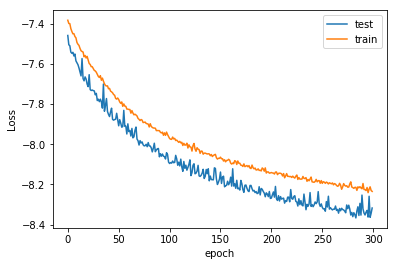

In [23]:
val_loss = np.asarray(history.history['val_loss'])
loss = np.asarray(history.history['loss'])
plt.plot(np.log(val_loss), label='test')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

In [24]:
p_train = model.predict([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']])

In [25]:
def plot_JEC( xyls ):
    plt.figure(figsize=(6,6))
    plt.grid()
    for X,Y,L in xyls:
        plt.scatter( X,Y, label=L, alpha=0.5 , marker='.')
    plt.xlim((0.8,1.2))
    plt.ylim((0.8,1.2))
    plt.hlines(1., 0.8,1.2)
    plt.vlines(1., 0.8,1.2)
    plt.xlabel( 'True JEC')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

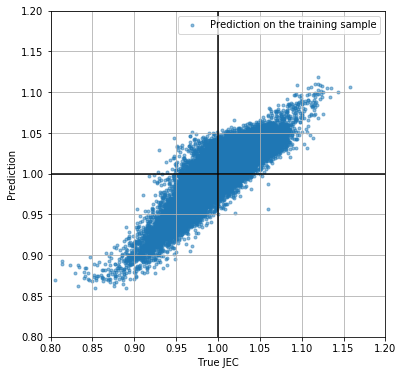

In [26]:
plot_JEC([(df_dict_jets['jet_jes'], p_train, 'Prediction on the training sample')])